# Trial of finetuning

Ref: https://huggingface.co/learn/cookbook/en/fine_tuning_smol_vlm_sft_trl

In [1]:
!pip install  -U -q transformers==4.46.3 trl==0.12.1 datasets==3.1.0 bitsandbytes==0.45.0 peft==0.13.2 accelerate==1.1.1
# Tested with transformers==4.46.3, trl==0.12.1, datasets==3.1.0, bitsandbytes==0.45.0, peft==0.13.2, accelerate==1.1.1

In [2]:
!pip install -q flash-attn --no-build-isolation

In [3]:
!pip install -q tensorboard

In [4]:
import torch
import time

In [5]:
print(torch.__version__)

2.5.1


In [6]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [7]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample["query"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["label"][0]}],
        },
    ]

In [8]:
from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=["train[:10%]", "val[:10%]", "test[:10%]"])

In [9]:
train_dataset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine'],
    num_rows: 2830
})

In [10]:
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>,
 'query': 'Is the value of Favorable 38 in 2015?',
 'label': ['Yes'],
 'human_or_machine': 0}

In [11]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [12]:
train_dataset[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Yes'}]}]

### Load chartllama using load_dataset

In [13]:
# This method does not work (loading from Huggingface hub)
#dataset_CL = "./chartllama_data"
#train_CL = load_dataset(dataset_CL)

In [15]:
# Data loading from the local drive
dataset = load_dataset('json', data_files=['chartllama_data/box_chart_100examples_simplified_qa.json',
                                           'chartllama_data/candlestick_chart_100examples_simplified_qa.json',
                                           'chartllama_data/funnel_chart_100examples_simplified_qa.json',
                                           'chartllama_data/gantt_chart_100examples_simplified_qa.json',
                                           'chartllama_data/heatmap_chart_100examples_simplified_qa.json',
                                           'chartllama_data/polar_chart_100examples_simplified_qa.json',
                                           'chartllama_data/scatter_chart_100examples_simplified_qa.json'
                                          ]
                      )


In [16]:
dataset['train']

Dataset({
    features: ['id', 'image', 'model', 'conversations'],
    num_rows: 980
})

In [17]:
for i in range(1):
    print(dataset['train'][i])

{'id': 'ours_simplified_qa_37_0', 'image': 'ours/box_chart/png/box_chart_100examples_37.png', 'model': '', 'conversations': [{'from': 'human', 'value': '<image>\nWhat is the title of the chart?'}, {'from': 'gpt', 'value': 'Analysis of smartphone usage patterns'}]}


In [18]:
from PIL import Image

def format_CL(sample):
    #print(sample)
    image_path = './chartllama_data/'+ sample['image']
    image_object = Image.open(image_path).convert('RGB')
    output = {"id": sample['id'], 'image': image_object, 'conversations': sample['conversations']}
    return output

In [19]:
train_CL_dataset = [format_CL(sample) for sample in dataset['train']]

In [20]:
train_CL_dataset[1]

{'id': 'ours_simplified_qa_56_2',
 'image': <PIL.Image.Image image mode=RGB size=1000x700>,
 'conversations': [{'from': 'human',
   'value': 'What are the outliers in the Microwave usage data?\n<image>'},
  {'from': 'gpt', 'value': 'None'}]}

### Load the model & check the performance

In [21]:
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

model_id = "HuggingFaceTB/SmolVLM-Base"

In [22]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [23]:
train_dataset[1]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text',
    'text': 'How many values are below 40 in Unfavorable graph?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': '6'}]}]

In [24]:
train_dataset[1][1:2]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text',
    'text': 'How many values are below 40 in Unfavorable graph?'}]}]

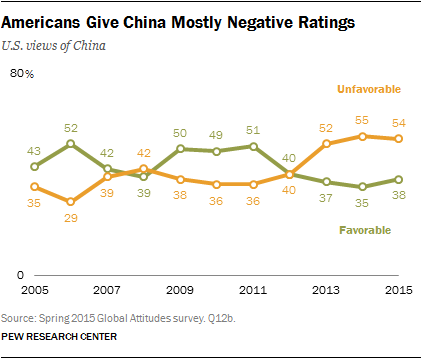

In [25]:
train_dataset[1][1]["content"][0]["image"]

In [26]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2], add_generation_prompt=True  # Use the sample without the system message
    )

    image_inputs = []
    image = sample[1]["content"][0]["image"]
    if image.mode != "RGB":
        image = image.convert("RGB")
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        # text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [28]:
train_dataset[1]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text',
    'text': 'How many values are below 40 in Unfavorable graph?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': '6'}]}]

In [27]:
output = generate_text_from_sample(model, processor, train_dataset[1])
output

' 2015-03-28 15:00'

In [68]:
import gc
import time


def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.06 GB


### Fine tuning

In [69]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [70]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["down_proj", "o_proj", "k_proj", "q_proj", "gate_proj", "up_proj", "v_proj"],
    use_dora=True,
    init_lora_weights="gaussian",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 11,269,248 || all params: 2,257,542,128 || trainable%: 0.4992


In [71]:
from trl import SFTConfig

# Configure training arguments using SFTConfig
training_args = SFTConfig(
    output_dir="smolvlm-instruct-trl-sft-ChartQA",
    max_seq_length=1024,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=25,
    save_total_limit=1,
    optim="adamw_torch_fused",
    bf16=True,
    #push_to_hub=True,
    #report_to="tensorboard",
    remove_unused_columns=False,
    gradient_checkpointing=True,
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
)

In [72]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
    processor.tokenizer.additional_special_tokens.index("<image>")
]


def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    image_inputs = []
    for example in examples:
        image = example[1]["content"][0]["image"]
        if image.mode != "RGB":
            image = image.convert("RGB")
        image_inputs.append([image])

    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels
    labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels

    return batch

In [73]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    #tokenizer=processor.tokenizer,
)

In [74]:
start_time = time.time()
trainer.train()
end_time = time.time()
print("Time taken:", (end_time - start_time)/60)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/ricky732/anaconda3/envs/vlm/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss


KeyboardInterrupt: 

In [ ]:
trainer.save_model(training_args.output_dir)

### Testing the Fine-Tuned Model

In [ ]:
clear_memory()

In [ ]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
adapter_path = "sergiopaniego/smolvlm-instruct-trl-sft-ChartQA"
model.load_adapter(adapter_path)

In [ ]:
test_dataset[20][:2]

In [ ]:
test_dataset[20][1]["content"][0]["image"]

In [ ]:
output = generate_text_from_sample(model, processor, test_dataset[20])
output